In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [8]:
df=pd.read_csv('../../Database/DB_v1.csv',index_col=False)
df=df.drop(['Unnamed: 0'],axis=1)
# scaler=StandardScaler()


In [14]:
y=df['DEF_PAY']
# X=scaler.fit_transform(df.drop(['DEF_PAY'],axis=1))
X=df.drop(['DEF_PAY'],axis=1)

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
import joblib

In [11]:
def gridSearch(model,params,X,Y,VALID_SIZE,FOLDS=10):
    skf = StratifiedKFold(n_splits=FOLDS)
    scoring = {'AUC': 'roc_auc', 'Accuracy':'accuracy'}    
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=VALID_SIZE, shuffle=True)
    class_weightsTrain = class_weight.compute_class_weight('balanced',np.unique(Y_train),Y_train)
    gs = GridSearchCV(model, cv=skf, param_grid=params, return_train_score=True, n_jobs=-1,refit='AUC')
    gs.fit(X_train, Y_train)
    print(gs.best_estimator_)
    print(np.abs(gs.best_score_))
    return gs,X_test,Y_test

In [12]:

param_grid = {
    'solver': ['adam'],
    'max_iter': [100,300,200],
    'alpha': 10.0** -np.arange(1, 4),
    'hidden_layer_sizes':(70,100,200),
    'activation': ["logistic","tanh"]
}
mlp = MLPClassifier(early_stopping=True)
gs,_,_=gridSearch(mlp,param_grid,X,y,0.2)
joblib.dump(gs, 'gs_object.pkl') #se guarda el gs para su posterior uso

/home/sht/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=15648    0
680      0
20556    0
13096    0
3729     0
        ..
21678    0
26639    0
29201    1
21476    0
14951    0
Name: DEF_PAY, Length: 24000, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


KeyboardInterrupt: 

In [15]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
import scikitplot as skplt#Esta librería toca instalarla "conda install -c conda-forge scikit-plot"
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE 

def experimentar(X,Y,oversampling=False):
    """ función para realizar experimentos con el MLP
    x: matriz de numpy con caracteristicas
    y: vector numpy con las variables a predecir
    num_hidden_layers: list de enteros con el numero de capdas
        ocultas a usar
    num_neurons: list de enteros con el numero de neuronas a usar
    
    Retorna: dataframe con 4 columnas:
        - numero de capas, numero de neuronas
        - promedio de error prueba (exactitud/eficiencia) de claisficacion y desviación estandar        
    """
    #Validamos el modelo
    Folds = 10
    skf = StratifiedKFold(n_splits=Folds)
    resultados = pd.DataFrame()
    idx = 0
    Acc = []
    Auc= []

    for j, (train, test) in enumerate(skf.split(X, Y)):
        Xtrain= X[train,:]
        Ytrain = Y[train]
        Xtest = X[test, :]
        Ytest = Y[test]
        #Normalizamos los datos
        scaler = StandardScaler().fit(X= Xtrain)       
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        model = MLPClassifier(activation='tanh', alpha=0.1, early_stopping=True,
              hidden_layer_sizes=100, max_iter=300)
        if oversampling:
            sm = SMOTE(random_state=42)
            Xtrain, Ytrain = sm.fit_resample(Xtrain, Ytrain)
            
        model.fit(X=Xtrain, y=Ytrain)
        Yest = model.predict_proba(Xtest)
        
        Acc.append(balanced_accuracy_score(Ytest,np.argmax(Yest, 1)))
        aux=roc_auc_score(Ytest,Yest[:,1])
        Auc.append(aux)
    skplt.metrics.plot_confusion_matrix(Ytest,np.argmax(Yest, 1),normalize=True) #matriz de confusión
    skplt.metrics.plot_roc(Ytest,Yest)
    print(classification_report(Ytest,np.argmax(Yest, 1)))
    
    resultados.loc[idx,'AUC medio'] = np.mean(Auc)
    resultados.loc[idx,'AUC intervalo de confianza'] = np.std(Auc)
    resultados.loc[idx,'Accuracy medio'] = np.mean(Acc)
    resultados.loc[idx,'Accuracy intervalo de confianza'] = np.std(Acc)
    return (resultados)

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      2337
           1       0.69      0.38      0.49       663

    accuracy                           0.82      3000
   macro avg       0.77      0.66      0.69      3000
weighted avg       0.81      0.82      0.80      3000



,AUC medio,AUC intervalo de confianza,Accuracy medio,Accuracy intervalo de confianza
0,0.765428,0.02033,0.659177,0.018904


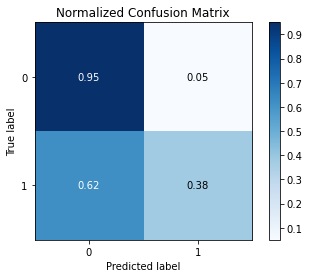

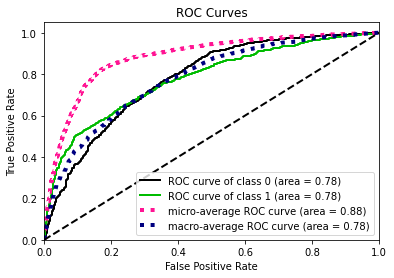

In [17]:
experimentar(np.array(X),y)

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      2337
           1       0.47      0.63      0.54       663

    accuracy                           0.76      3000
   macro avg       0.68      0.72      0.69      3000
weighted avg       0.79      0.76      0.77      3000



,AUC medio,AUC intervalo de confianza,Accuracy medio,Accuracy intervalo de confianza
0,0.771901,0.020207,0.704556,0.015381


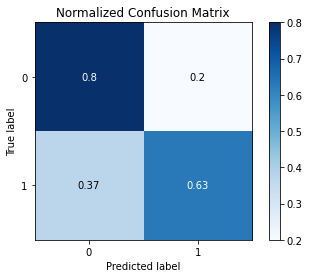

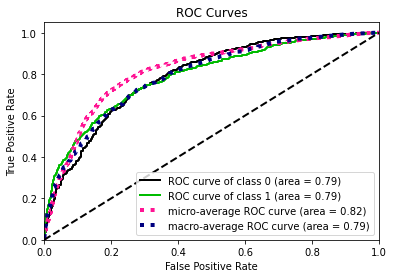

In [11]:
experimentar(X,y,oversampling=True)

In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
import time
def entrenamiento_sin_seleccion_caracteristicas(splits, X, Y):

    Balan_Acc = np.ones(splits)
    roc_auc = np.ones(splits)
    times = np.ones(splits)
    j = 0
    skf = StratifiedKFold(n_splits=10)
    
    for train_index, test_index in skf.split(X,Y):
        X_train, X_test = X[train_index,:], X[test_index,:]
        y_train, y_test = Y[train_index], Y[test_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        clf = MLPClassifier(activation='tanh', alpha=0.1, early_stopping=True,
              hidden_layer_sizes=100, max_iter=300)
        #Aquí se entran y se valida el modelo sin hacer selección de características
        tiempo_i = time.time()
        clf.fit(X_train,y_train)
        # Validación del modelo
        Yest=clf.predict_proba(X_test)
        Balan_Acc[j] = balanced_accuracy_score(y_true=y_test, y_pred=np.argmax(Yest,1))
        roc_auc[j]=roc_auc_score(y_test,Yest[:,1])
        times[j] = time.time()-tiempo_i
        j+=1

    return np.mean(Balan_Acc), np.std(Balan_Acc),np.mean(roc_auc), np.std(roc_auc), np.mean(times)

def entrenamiento_pca_ext_caracteristicas(splits,n_comp, X, Y):

    #Implemetamos la metodología de validación 
    Balan_Acc = np.ones(splits)
    roc_auc = np.ones(splits)
    times = np.ones(splits)
    j = 0
    skf = StratifiedKFold(n_splits=splits)
    for train_index, test_index in skf.split(X,Y):  
        X_train, X_test = X[train_index,:], X[test_index,:]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # ¿es necesario estandarizacion de datos?
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
 
        #dejar el mismo nombre del objeto 
        pca = PCA(n_components= n_comp)
        # para calcular costo computacional
        tiempo_i = time.time()
        # es recomendable usar el metodo que ajusta y transforma
        X_train_pca = pca.fit_transform(X= X_train)
        # aca solo usar el metodo de transformar (ya que en el anterior el pca se ajusto)
        X_test_pca = pca.transform(X= X_test)
        # entrenar el modelo usando las caractieristicas transformadas por PCA
        clf = MLPClassifier(activation='tanh', alpha=0.1, early_stopping=True,
              hidden_layer_sizes=100, max_iter=300)
        clf.fit(X= X_train_pca, y=y_train)
        tiempo_o = time.time()-tiempo_i
        Yest=clf.predict_proba(X_test_pca)
        Balan_Acc[j] = balanced_accuracy_score(y_true=y_test, y_pred=np.argmax(Yest,1))
        roc_auc[j]=roc_auc_score(y_test,Yest[:,1])
        times[j] = tiempo_o
        j+=1


    return np.mean(Balan_Acc), np.std(Balan_Acc),np.mean(roc_auc), np.std(roc_auc), np.mean(times)

def experimentar_PCA(n_comp, X, Y):

    df = pd.DataFrame()
    idx = 0
    split_number = 10
    #Sin selección de características
    Acc,ic_Acc,ROC,ic_ROC,t_ex = entrenamiento_sin_seleccion_caracteristicas(split_number, X,Y)  
    df.loc[idx,'CON_EXTRA'] = 'NO'
    df.loc[idx,'NUM_COMP'] = X.shape[1] # se usan todas las caracteristicas
    df.loc[idx,'BALANCE_ACC'] = Acc
    df.loc[idx,'IC_ACC'] = ic_Acc
    df.loc[idx,'ROC_AUC'] = ROC
    df.loc[idx,'IC_ROC_AUC'] = ic_ROC
    df.loc[idx,'T_EJECUCION'] = t_ex
    idx+=1
    print("termina experimento sin selección")
    #Con selección de características
    
    for f in n_comp:
        #Implemetamos la metodología de validación 
        Acc,ic_Acc,ROC,ic_ROC,t_exx = entrenamiento_pca_ext_caracteristicas(splits=5,n_comp=f, X= X,Y=Y)
        df.loc[idx,'CON_EXTRA'] = 'SI'
        df.loc[idx,'NUM_COMP'] = f
        df.loc[idx,'BALANCE_ACC'] = Acc
        df.loc[idx,'IC_ACC'] = ic_Acc
        df.loc[idx,'ROC_AUC'] = ROC
        df.loc[idx,'IC_ROC_AUC'] = ic_ROC
        df.loc[idx,'T_EJECUCION'] = t_ex
        idx+=1
    return df

In [19]:
experimentar_PCA(n_comp=[], X= np.array(X), Y = y)

termina experimento sin selección


,CON_EXTRA,NUM_COMP,BALANCE_ACC,IC_ACC,ROC_AUC,IC_ROC_AUC,T_EJECUCION
0,NO,23.0,0.657543,0.015639,0.767963,0.019354,13.245008
